In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


In [30]:


# Function to calculate TMSD
def calculate_tmsd(track, max_tau):
    n_points = len(track)
    tmsd_values = []

    for tau in range(1, max_tau + 1):
        if n_points - tau != 0:
            displacement = track.iloc[tau:].values - track.iloc[:-tau].values
            squared_displacement = (displacement**2).sum(axis=1)
            tau_sum = squared_displacement.sum()

            tmsd_values.append(tau_sum / (n_points - tau))
        else:
            tmsd_values.append(np.nan)  # Handle division by zero, set TMSD to NaN

    return tmsd_values

# Power-law function
def power_law(tau, k, a):
    return k * tau**a

# Load the CSV file into a DataFrame
#input_file_path = 'F:/Position/PVRCA300_Average_Position.csv'
#time_interval_per_timepoint = 11.27
#input_file_path = 'F:/Position/23_06_E1_PVDRNz_Position.csv'
#time_interval_per_timepoint = 8.67
#input_file_path = 'F:/Position/dnpvr2a fulltracks1_Position.csv'
#time_interval_per_timepoint = 14.22
#input_file_path = 'F:/Position/23_02_E1z_Position.csv'
#time_interval_per_timepoint = 23.33
#input_file_path = 'F:/Position/23_02_E2y_Position.csv'
#time_interval_per_timepoint = 27
#input_file_path = 'F:/Position/22_12z_Position.csv'
#time_interval_per_timepoint = 25.2
#input_file_path = 'F:/Position/srp che 3_Subset_Averagez_Position.csv'
#time_interval_per_timepoint = 26.76
#input_file_path = 'F:/Position/23_03_E4z_Position.csv'
#time_interval_per_timepoint = 8.7
#input_file_path = 'F:/Position/23_03_E3X2z_Position.csv'
#time_interval_per_timepoint = 10.2
input_file_path = 'D:/Position_ABM/ABM24_H075.csv'
time_interval_per_timepoint = 20



#c = 'blue'
#c = 'orange'
#c = 'green'
c = 'maroon'

x_max = 450 # User-defined value for x-max
timepoints = int(x_max / time_interval_per_timepoint)

displacement_df = pd.read_csv(input_file_path)#, skiprows=2)


Number of unique TrackID values: 100


C:\Users\JACOB-ASMAT\AppData\Local\Temp\ipykernel_19744\3678497876.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tmsd_df = pd.concat([tmsd_df, pd.DataFrame([{'TrackID': track_id, **dict(zip([f'TMSD_{tau}' for tau in range(1, len(track_tmsd_values) + 1)], track_tmsd_values))}])], ignore_index=True)



k value: 0.03947983389077618
Standard Error for k: 0.0011591012607756457

Alpha (a) value: 1.486903773637395
Standard Error for a: 0.005047214843481327


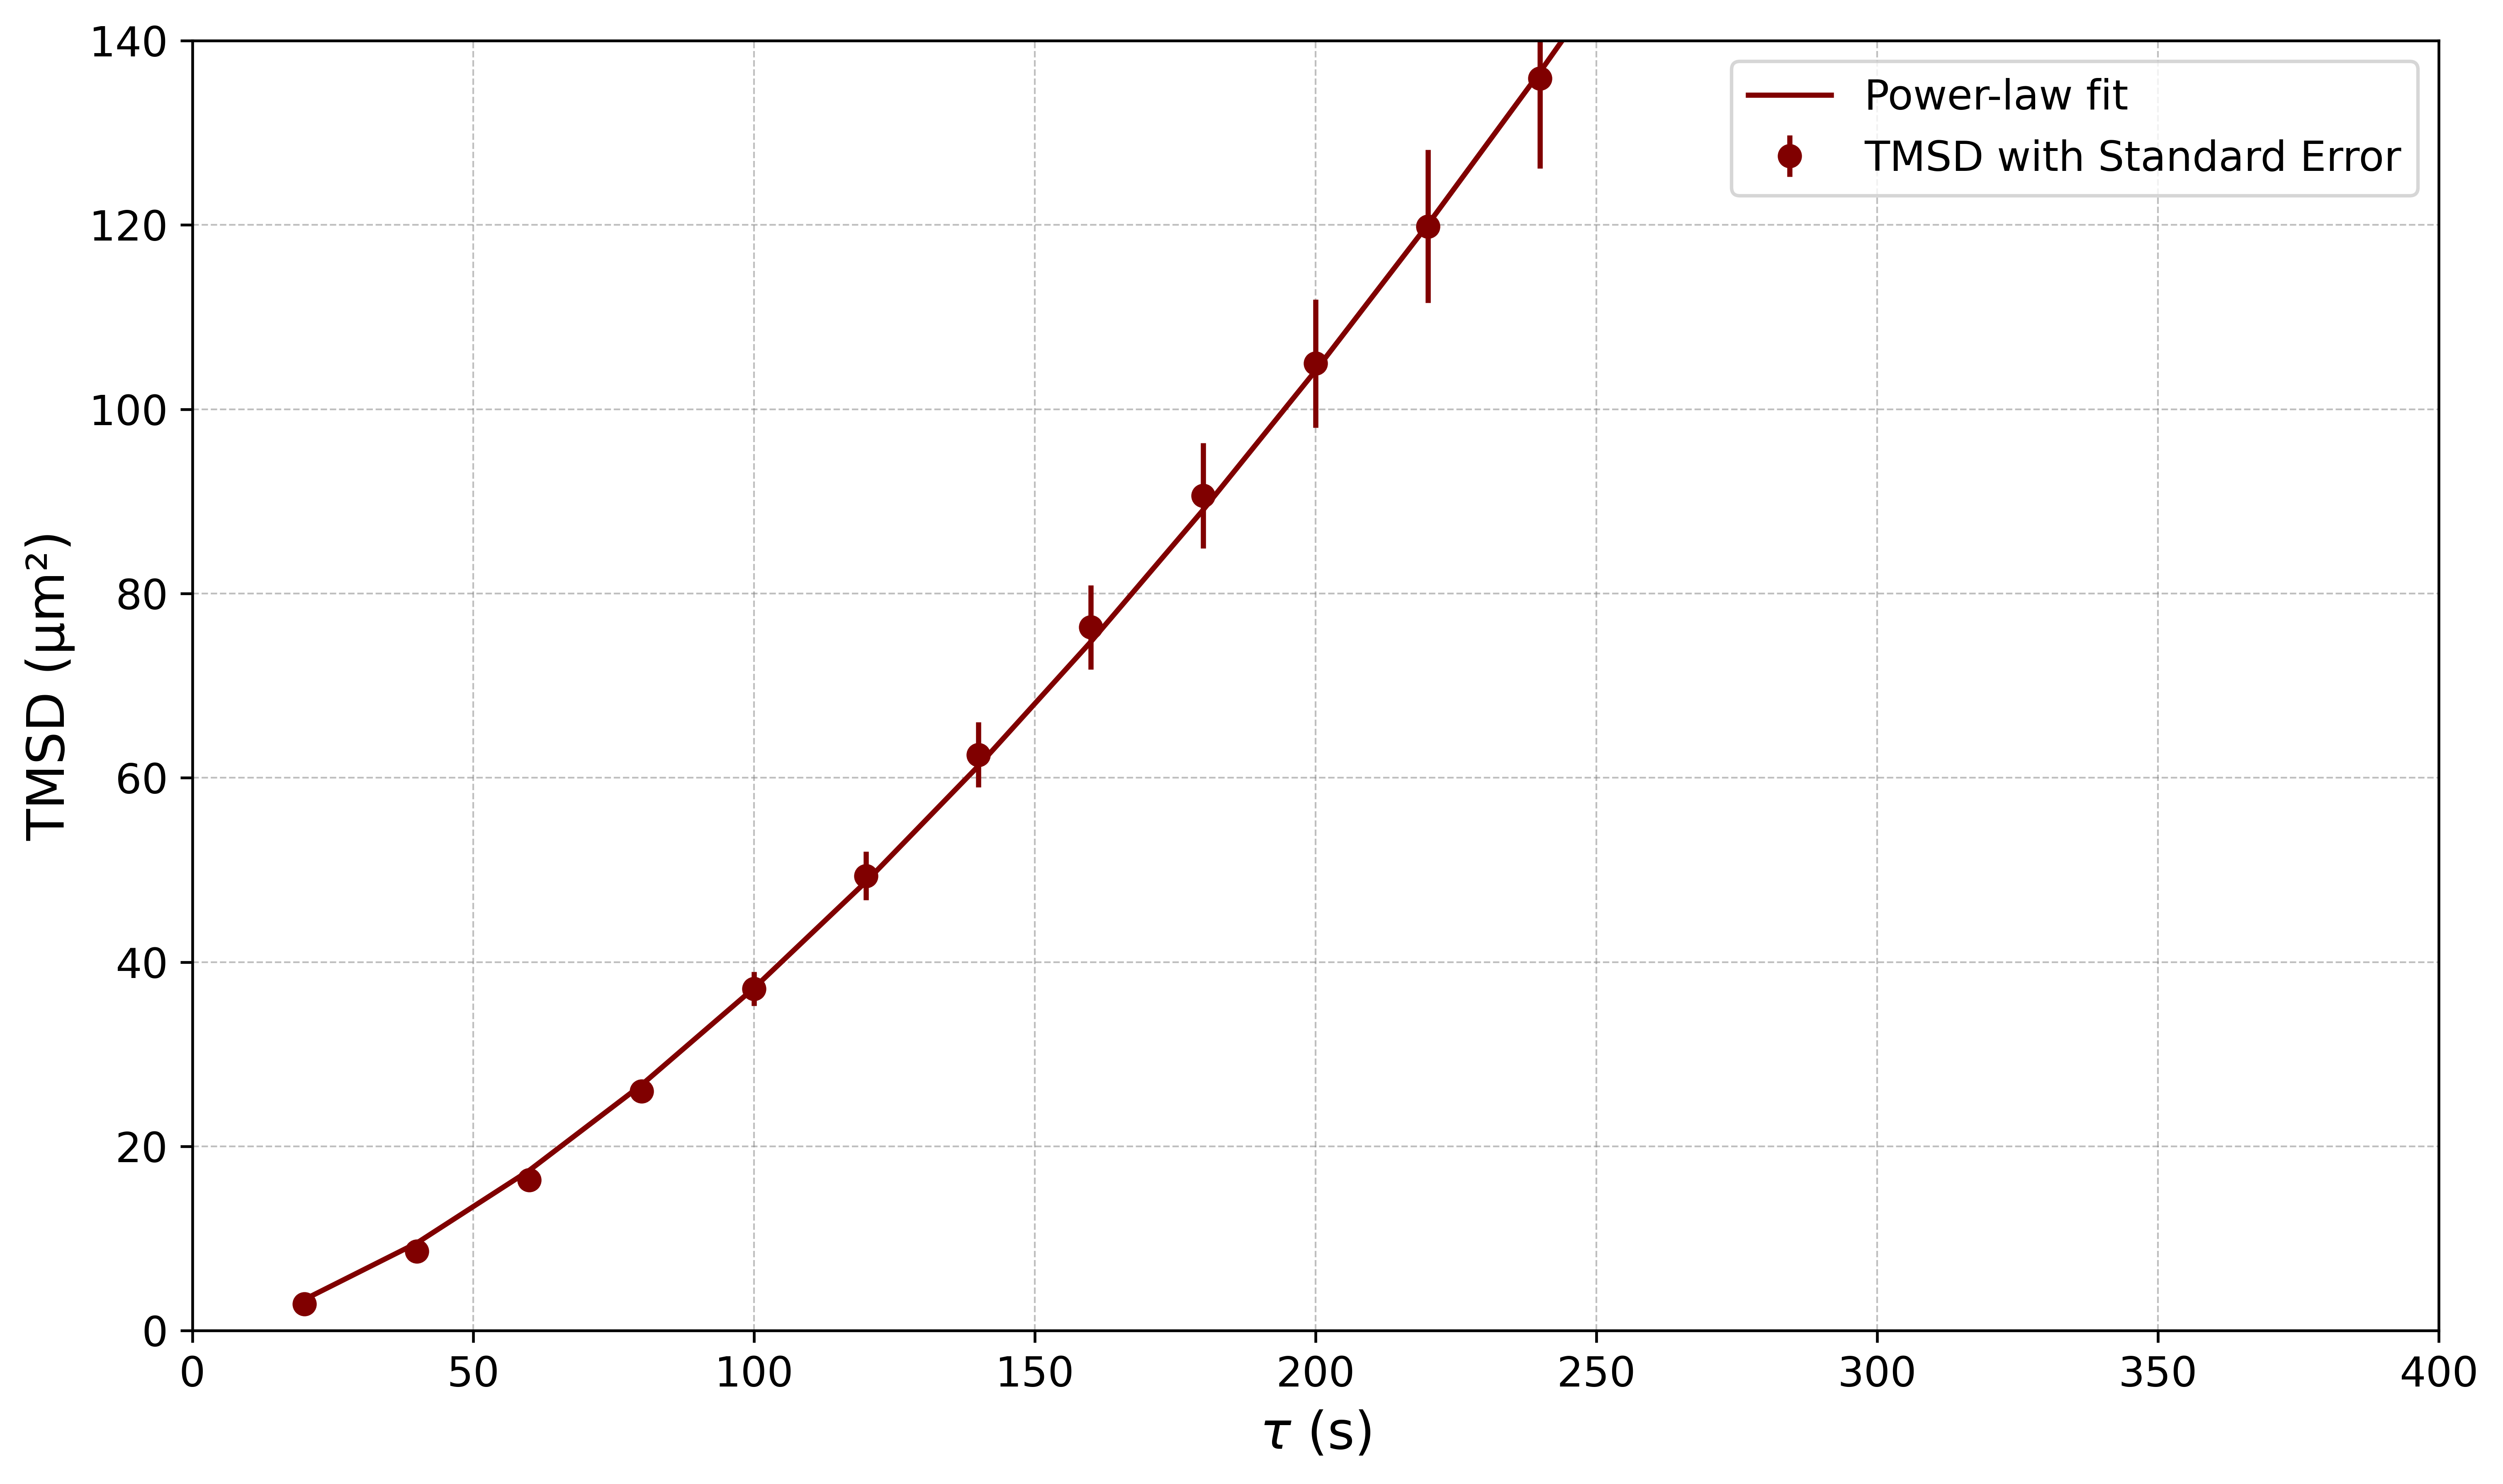

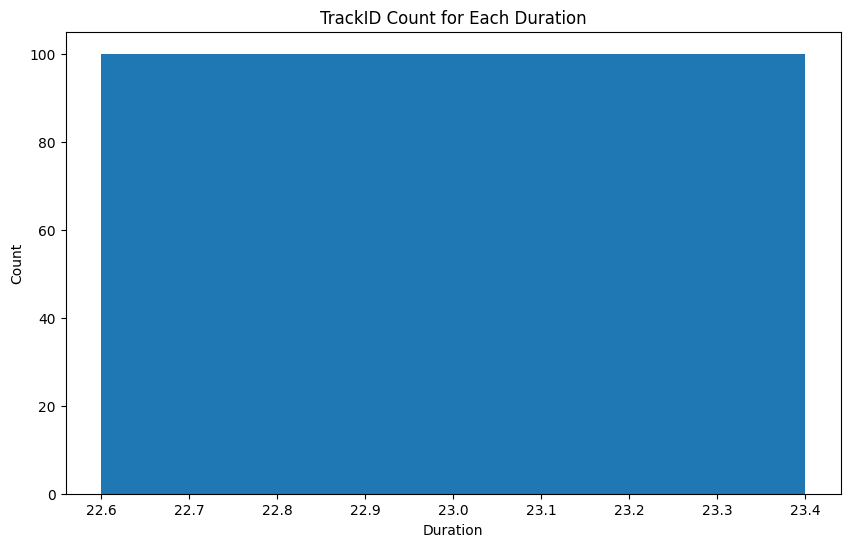


Power Law Equation:
TMSD(τ) = 0.0395 * τ^1.487


In [31]:

# Filter out data points beyond x-max (in terms of timepoints)
displacement_df = displacement_df[displacement_df['Time'] <= timepoints]

taumax = 50

color_palette = sns.color_palette("tab10")



# Calculate the number of unique TrackID values
unique_track_ids = displacement_df['TrackID'].nunique()
print("Number of unique TrackID values:", unique_track_ids)

# Group by TrackID and calculate the time point difference for each group
track_duration_df = displacement_df.groupby('TrackID')['Time'].agg(lambda x: x.max() - x.min() + 1).reset_index()

# Count the number of TrackIDs for each duration
duration_counts = track_duration_df['Time'].value_counts().reset_index()

# Rename the columns for clarity
duration_counts.columns = ['Duration', 'Count']

# Create an empty DataFrame to store TMSD values
tmsd_df = pd.DataFrame(columns=['TrackID'] + [f'TMSD_{tau}' for tau in range(1, taumax + 1)])

# Calculate TMSD for each time lag for each unique track
for track_id, track_data in displacement_df.groupby('TrackID'):
    max_tau = min(taumax, len(track_data))  # Set a maximum value for tau based on the length of track_data
    
    # Reset TMSD calculation for each track
    track_tmsd_values = calculate_tmsd(track_data[['Position X', 'Position Y', 'Position Z']], max_tau)
    
    # Append TMSD values to the DataFrame
    tmsd_df = pd.concat([tmsd_df, pd.DataFrame([{'TrackID': track_id, **dict(zip([f'TMSD_{tau}' for tau in range(1, len(track_tmsd_values) + 1)], track_tmsd_values))}])], ignore_index=True)


# Calculate the average TMSD values at each time lag
average_tmsd_values = np.mean(tmsd_df[[f'TMSD_{tau}' for tau in range(1, taumax)]], axis=0)
tmsd_stderr_values = np.std(tmsd_df[[f'TMSD_{tau}' for tau in range(1, taumax)]], axis=0) / np.sqrt(len(tmsd_df))

# Calculate the true time values for the x-axis
true_time_values = np.arange(1,duration_counts['Duration'].max()) * time_interval_per_timepoint

# Remove rows with NaN or inf values
common_length = min(len(true_time_values), len(average_tmsd_values), len(tmsd_stderr_values))
true_time_values = true_time_values[:common_length]
average_tmsd_values = average_tmsd_values[:common_length]
tmsd_stderr_values = tmsd_stderr_values[:common_length]

# Remove the last row from average_tmsd_values
average_tmsd_values = average_tmsd_values[:-1]
tmsd_stderr_values = tmsd_stderr_values[:-1]
true_time_values = true_time_values[:-1]

# Fit a power-law curve on the cropped data
popt, pcov = curve_fit(power_law, true_time_values, average_tmsd_values)

# Extract standard errors
perr = np.sqrt(np.diag(pcov))

# Calculate alpha (a) and H values
alpha = popt[1]
kalpha = popt[0]
H = alpha / 2

# Print the values
print("\nk value:", kalpha)
#print("Hurst (H) value:", H)
print(f"Standard Error for k: {perr[0]}")
print("\nAlpha (a) value:", alpha)
print(f"Standard Error for a: {perr[1]}")

# Plot the results with specified labels, colors, and axis limits
plt.figure(figsize=(10, 6), dpi=600)
plt.errorbar(
    true_time_values,
    average_tmsd_values,
    yerr=tmsd_stderr_values,
    fmt='o',
    label='TMSD with Standard Error',
    color=c
)

plt.plot(true_time_values, power_law(true_time_values, *popt), '-', color=c, label='Power-law fit')

plt.xlabel(r'$\tau$ (s)', fontsize=15)
plt.ylabel('TMSD (µm²)', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
# Set x and y-axis limits
plt.xlim(0, 400)
plt.ylim(0, 140)
# Add vertical and horizontal gridlines with custom labels
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.show()

# Plot a bar chart for track lengths
plt.figure(figsize=(10, 6))
plt.bar(duration_counts['Duration'], duration_counts['Count'])
plt.xlabel('Duration')
plt.ylabel('Count')
plt.title('TrackID Count for Each Duration')
plt.show()

# Print the power law equation
print("\nPower Law Equation:")
print(f'TMSD(τ) = {popt[0]:.4f} * τ^{popt[1]:.3f}')